## ***UK Used Car Listing Data*** 🚕
Oriel Asaraf
ID 313453540

The aim of this project is to forecast the price of a car. To achieved this goal, I found a dataset from Kaggle published in 2022 which contain more than 818,000 rows of records.
Each row represents one vehicle with more than 30 columns each represents a attribute oif the advert, such as the price, car make, model, variant, transmission, engine size, body type etc..
The main challenges in this project was the nature of the data. First, the data contains a lot of categorical features which are complicated to use in state-of-the-art models. Secondly, the  the target (price) and the other numerical features are not meeting normal distribution.
To handled the categorical features, a deep exploration of the nature of the features has been applied, including handling missing data, remove categorical data with high number of uniques values, remove features with high correlation, codding etc.
To handled the anormal distribution, I try to remove outliers and see if the distribution has improved. The optimal multiplier has been found and use.
After pre-processing, model selection, fine tuning, and exploration of feature importance I found an accuracy of 97% of the forecasting.

As part of this project, many experiments were conducted to improve the prediction of the target column, but I did not mention them to avoid overloading the notebook.

In [3]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as XGB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
# Suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download latest version
path = kagglehub.dataset_download("guanhaopeng/uk-used-car-market")

print("Path to dataset files:", path)

csv_file_path = f"{path}/all_car_adverts.csv"
df = pd.read_csv(csv_file_path)


100%|██████████| 40.4M/40.4M [00:00<00:00, 73.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/guanhaopeng/uk-used-car-market/versions/4


In [12]:
SKIP_FINDING_HYPER_PARAMTER = True
SKIP_FINFING_BEST_MODEL = True
SKIP_RUN_EXPIRIMENT = True

# **Part 1: Data Exploration and Pre-processing**


At the start, let's understand our data. The dataset contains 818,456 rows and 32 columns. The columns include binary, categorical, and numeric types, but some of them are not needed.

In [ ]:
df

,Unnamed: 0,make,model,variant,car_price,car_badges,car_title,car_sub_title,car_attention_grabber,car_specs,...,num_owner,ulez,full_service,part_service,part_warranty,full_dealership,first_year_road_tax,brand_new,finance_available,discounted
0,0,AC,Cobra,NaN,89995.0,NaN,AC Cobra,4.9 MK IV CRS 2dr,GENUINE AC COBRA CRS 522 BHP,"2001 (X reg), Convertible, 14,400 miles, 4.9L,...",...,5.0,0,0,0,0,0,0,0,0,0
1,1,AC,Cobra,NaN,92500.0,'',AC Cobra,378 - MkIV,PHYSICAL CAR!,"2019 (T reg), Convertible, 650 miles, Manual, ...",...,NaN,0,0,0,0,0,0,0,0,0
2,2,AC,Cobra,NaN,109995.0,'',AC Cobra,MK1V 212 SC. 3.5 V8 350 BHP LOTUS TWIN TURBO. ...,FULL CARBON FIBRE BODY.,"2000 (X reg), Convertible, 21,600 miles, 3.5L,...",...,3.0,0,0,0,0,0,0,0,0,0
3,3,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV 2dr,ABSOLUTELY STUNNING,"1989 (F reg), Convertible, 2,750 miles, Manual...",...,NaN,0,0,0,0,0,0,0,0,0
4,4,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV With Factory Lightweight Engine 5.0 2dr,'STAGE 3' SVO ENGINE,"1989 (E reg), Convertible, 15,142 miles, 5.0L,...",...,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818451,818451,Westfield,Sport,NaN,8595.0,NaN,Westfield Sport,NaN,NaN,"1995 (M reg), Convertible, 5,000 miles, Manual...",...,4.0,0,0,0,0,0,0,0,0,0
818452,818452,Wolseley,1500,NaN,3495.0,NaN,Wolseley 1500,NaN,Classic 1962 WOLSELEY 1500.,"1962, Saloon, 56,000 miles, Manual, Petrol, 5 ...",...,5.0,0,0,0,0,0,0,0,0,0
818453,818453,Yamaha,Yxz 1000r,NaN,22990.0,'Finance available',Yamaha YXZ 1000R,NaN,2022 PLATE WITH 772KM,"2022 (22 reg), 480 miles",...,NaN,0,0,0,0,0,0,0,1,0
818454,818454,Yamaha,NaN,Unlisted,22990.0,'Finance available',Yamaha YXZ 1000R,NaN,2022 PLATE WITH 772KM,"2022 (22 reg), 480 miles",...,NaN,0,0,0,0,0,0,0,1,0


In [ ]:
df.describe()

,Unnamed: 0,car_price,car_seller_rating,miles,engine_vol,engine_size,num_owner,ulez,full_service,part_service,part_warranty,full_dealership,first_year_road_tax,brand_new,finance_available,discounted
count,818456.000000,8.184560e+05,644191.000000,763703.000000,803010.000000,814247.000000,442596.000000,818456.000000,818456.000000,818456.000000,818456.000000,818456.000000,818456.000000,818456.000000,818456.000000,818456.000000
mean,409227.500000,2.011859e+04,4.649465,48735.854328,1.860284,170.134123,2.097290,0.815449,0.108105,0.013059,0.063693,0.035079,0.063693,0.066233,0.716983,0.045162
std,236268.040299,2.224110e+04,0.433626,36520.141907,0.752763,92.141443,1.265622,0.387933,0.310513,0.113526,0.244206,0.183981,0.244206,0.248690,0.450465,0.207659
min,0.000000,3.000000e+02,1.000000,2.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,204613.750000,8.990000e+03,4.600000,19441.000000,1.400000,115.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,409227.500000,1.500000e+04,4.700000,40267.000000,1.600000,148.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,613841.250000,2.450000e+04,4.900000,71215.500000,2.000000,190.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,818455.000000,3.199830e+06,5.000000,999999.000000,8.300000,2460.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see, the data is distributed across a wide range of values. The difference between the minimum and maximum values of the target feature is very high.

Let's explore the data!

First, I want to show how the distribution looks for the car price feature:

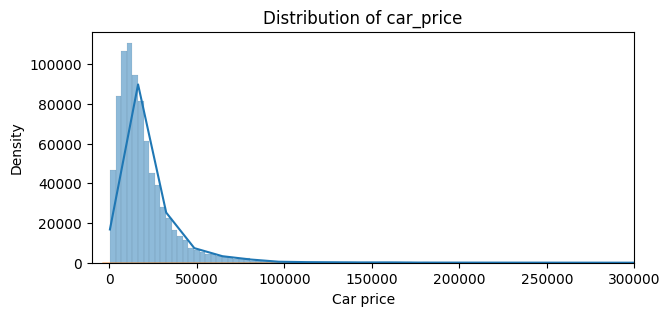

In [ ]:
plt.figure(figsize=(7, 3))
sns.histplot(df['car_price'], bins=1000, kde=True)
sns.kdeplot(df['car_price'], fill = True)
plt.xlabel('Car price')
plt.ylabel('Density')
plt.title('Distribution of car_price')
plt.xlim([-10000,300000])
plt.show()

As I can see, the car price distribution does not follow a normal distribution.

The graph has a right skew, which means there are a small number of car prices that are significantly higher than the mean.

Many models and approaches assume a normal distribution, making this a challenge in my project. To address this, I will normalize the data to ensure a more normal distribution for better predictions.

As I explained, my data is built from three types of features: categorical, binary, and numeric.

I will explore each of them separately.

## **Pre** **processing**

First, I want to check the percentage of null values in each column.

I cannot have null values in my rows, as this will affect the results of my model.

In [ ]:
missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_percentages

,0
Unnamed: 0,0.000000
make,0.000000
model,0.037021
variant,0.274786
car_price,0.000000
car_badges,2.076715
car_title,0.000000
car_sub_title,0.066833
car_attention_grabber,9.810301
car_specs,0.000000


**Missing Data:**
To handle missing data, I will remove columns with a high percentage (>15%) of missing values, as they are not informative enough. For the remaining missing values, I will handle them differently based on the type of column—categorical or numerical.

Before deleting all the columns above the threshold, I want to save the num_owner column separately. I plan to conduct an experiment with this data later.

The number of owners (num_owner) of a car is critical in determining the car price. As the number of owners increases, the price tends to decrease.

In [ ]:
num_owners_saved_df = df[['num_owner']].copy()

In [ ]:
# high percentage of missing values
threshold = 0.15  # Set threshold for missing values
df = df.loc[:, df.isnull().mean() < threshold]
missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_percentages

,0
Unnamed: 0,0.000000
make,0.000000
model,0.037021
variant,0.274786
car_price,0.000000
car_badges,2.076715
car_title,0.000000
car_sub_title,0.066833
car_attention_grabber,9.810301
car_specs,0.000000


# Handling Categorical Features
**After deleting the non-informative columns with too many missing values, I want to start processing the categorical features.**

First, I will understand the nature and distribution of the categorical features.

Our categorical features are:

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['make',
 'model',
 'variant',
 'car_badges',
 'car_title',
 'car_sub_title',
 'car_attention_grabber',
 'car_specs',
 'car_seller',
 'car_seller_location',
 'year',
 'reg',
 'body_type',
 'engine_size_unit',
 'transmission',
 'feul_type']

"Unnamed" is also a categorical feature. It appears to be numeric because all the values are numbers, but it is actually just the IDs of the rows. I will drop this feature.

In [ ]:
# Remove unnecessary columns i.e., 'Unnamed: 0'
df = df.drop(columns = 'Unnamed: 0' )

Let's examine our categorical data, and then I will handle it:

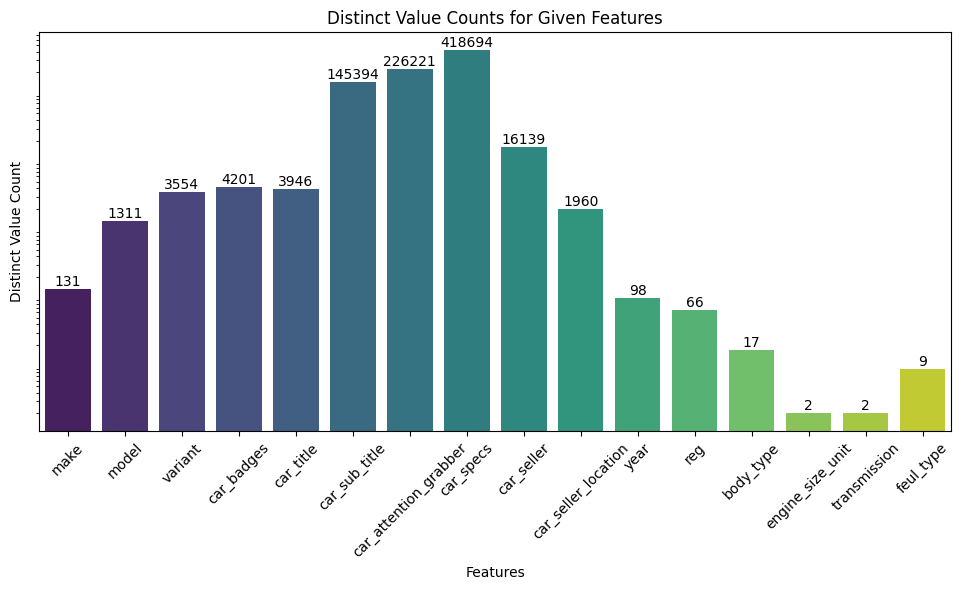

In [ ]:
def show_uniques_graph(categorical_col):
  plt.figure(figsize=(10, 6))

  sns.barplot(
      x=categorical_col,
      y=[df[col].nunique() for col in categorical_col],
      palette='viridis'
  )

  plt.yscale('log')
  plt.xlabel("Features")
  plt.ylabel("Distinct Value Count")
  plt.title("Distinct Value Counts for Given Features")
  plt.xticks(rotation=45)
  plt.tight_layout()

  for p in plt.gca().patches:
      height = p.get_height()
      plt.text(p.get_x() + p.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

  plt.gca().set_yticklabels([])
  plt.gca().tick_params(axis='y', left=False)

  plt.show()
show_uniques_graph(categorical_columns)

This graph shows us the distinct value counts for each categorical feature—the amount of unique values for each feature.

After some research, I've identified that there are columns which are not relevant at all to car price prediction, such as:
**car seller, car seller location, car subtitle, car attention grabber, car badges, car spec.**
These columns contain free text, and it will be very difficult for the model to learn from them. They seem very irrelevant, so I will drop them.

**Car title**: The car title feature is important, but it's also a free text feature. This feature combines the make and model, so I will save those columns separately, making this feature unnecessary as well.

**Variant**: After checking, I found that this column doesn't affect the price significantly and has too many unique values. Therefore, I will drop it as well.


In [ ]:
df = df.drop(columns=['car_specs', 'car_sub_title', 'car_attention_grabber', 'car_seller', 'car_seller_location','variant','car_title', 'car_badges'])

The dataset contains a column named "engine_size_unit." Upon reviewing the data, it is evident that engine size is described by two columns: **engine_size_unit** and **engine_size**. The engine size is measured in either PS or BHP units, with the majority of entries using PS as the unit of measurement. Therefore, I will convert the engine size values currently measured in BHP to PS and subsequently remove the "engine_size_unit" column.

In [ ]:
df.loc[df['engine_size_unit'] == 'bhp', 'engine_size'] *= 1.01442
df = df.drop(columns=['engine_size_unit'])

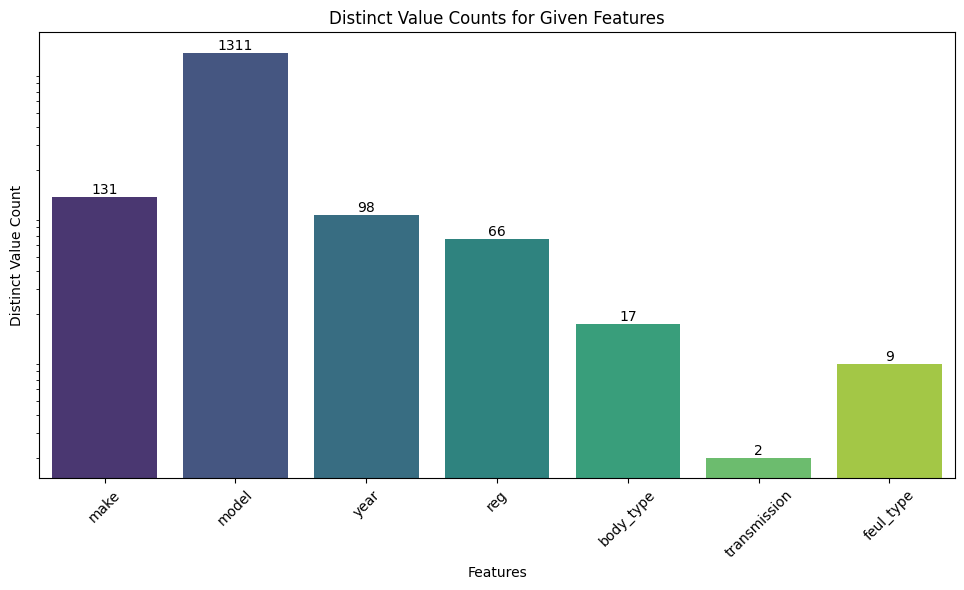

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
show_uniques_graph(categorical_columns)

In [ ]:
!pip install thefuzz
from thefuzz import fuzz, process

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.9 MB/s eta 0:00:00


In [ ]:
def get_fuzzy_unique_count(series, threshold=85):
    unique_values = list(series.unique())
    grouped_values = []

    for value in unique_values:
        matched = False
        for group in grouped_values:
            if fuzz.ratio(value, group[0]) >= threshold:
                group.append(value)
                matched = True
                break

        if not matched:
            grouped_values.append([value])

    return len(grouped_values)

def get_fuzzy_unique_counts(df, columns, threshold=85):
    return {col: get_fuzzy_unique_count(df[col], threshold) for col in columns}

column_names = [ 'reg', 'body_type', 'transmission', 'feul_type', 'model', 'make']
fuzzy_counts = get_fuzzy_unique_counts(df, column_names)

print(fuzzy_counts)

{'reg': 67, 'body_type': 18, 'transmission': 3, 'feul_type': 10, 'model': 1178, 'make': 131}


I used the fuzzy matching algorithm  to check for unique values that might not actually be unique, due to variations such as differences in letter case or missing characters.

The fuzz.ratio function from thefuzz library compares two strings based on their similarity using the Levenshtein distance, returning a score between 0 and 100. In the provided code, it groups similar values within a column by checking if their similarity score meets or exceeds the given threshold (85). This helps estimate the number of unique values while accounting for minor variations in spelling or formatting.

The results remained consistent across all features, with the exception of the "model" feature.

I will address the "model" feature separately.

**Reg:**

In some countries, vehicle registration plates include a code that indicates the year or period of registration. For example, in the UK, a car with a "T reg" plate was registered between August 1999 and July 2000, while an "X reg" plate corresponds to registrations between August 2000 and July 2001. These codes typically follow a structured pattern, allowing the registration year to be determined based on the "reg" value. By mapping these codes to specific years, they can be used for analysis.

However, this feature has a very high correlation with the "year" feature, which could lead to overfitting. Therefore, I am dropping this column.

In [ ]:
df = df.drop(columns=['reg'])

**Year:**

The "year" feature is categorical, but not entirely so. I will convert it into a numeric feature.

However, since there are 98 unique values, I find it hard to believe that cars being sold date back 98 years.

In [ ]:
unique_values = df['year'].unique()
unique_values

array(['2001', '2019', '2000', '1989', '2022', '2018', '2017', '2016',
       '2013', '2009', '2012', '2011', '2010', '2015', '2014', '2020',
       '2021', 'Hatchback', 'Convertible', '2008', '2007', '2006', '2003',
       '2004', '2005', '2002', '1995', '1999', '1998', '1997', '1996',
       'Saloon', 'SUV', 'Coupe', '1971', '1934', '1960', '1962', '1963',
       '1965', '1964', '1967', '1988', '1973', '1974', '1984', '1977',
       '1979', '1978', '1993', '1994', 'Automatic', 'Manual', 'Estate',
       '1991', '1970', '1955', '1956', '1983', '1959', '1961', '1966',
       '1986', '1980', '1985', '1987', '1990', '1976', 'MPV', '1992',
       '1982', '1949', '1953', '1969', '1968', '1972', 'Pickup',
       'Combi Van', 'Car Derived Van', '1981',
       'First year road tax included', '1954', '1958', '1940',
       '101 miles', '32', 'Minibus', 'Camper', '1950', '1957', '1975',
       '1951', '1937', '1936', '1952', '1079', '1935', '1938'],
      dtype=object)

As we can see from the results, there are some unrelated unique values, such as "101 miles" and "Pickup."

I will proceed with converting the column to numeric. Any value that does not represent a valid year will be converted to NaN.

Afterward, I will handle the missing values by removing those rows.

In [ ]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')

There are two unusual year values: 32 and 1079. First, I will check how many times they appear. If their occurrences are minimal, I will remove these rows, as they could negatively impact the analysis.

In [ ]:
count_32_1079 = df[df['year'].isin([32, 1079])].shape[0]
print(count_32_1079)

3


In [ ]:
df = df[~df['year'].isin([32, 1079])]

Let's examine the rest of the categorical values.

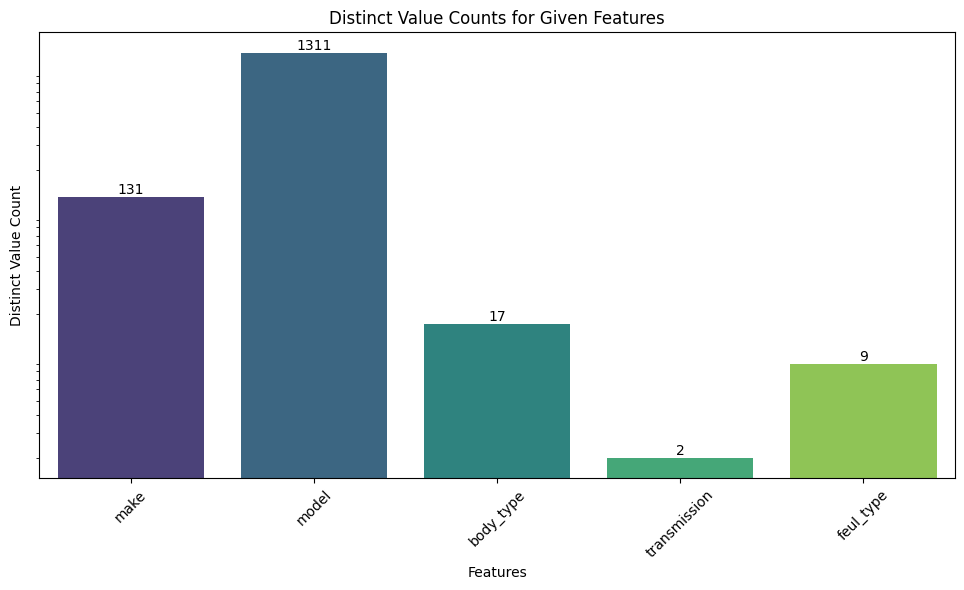

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
show_uniques_graph(categorical_columns)

**Filling Missing Data for Categorical Features**

Instead of simply dropping rows with missing values, I will group the data by the "make" feature (which represents the vehicle manufacturer). For each categorical feature, I will determine the most frequent value within each group and use it to fill in the missing data.

In [ ]:
# categorical missing data handled
cat_columns_with_missing = ['body_type', 'transmission', 'feul_type', 'model']
for col in cat_columns_with_missing:
    df[col] = df.groupby('make')[col].transform(
        lambda group: group.fillna(group.mode().iloc[0]) if not group.mode().empty else group
    )


After removing certain categories, we are left with two groups: categorical columns with a small number of unique values (except for the "model" feature).

I will apply one-hot encoding to these categorical columns.

For the "model" feature, I will use **hash encoding** to handle its high cardinality efficiently.

Hash encoding is a technique used to represent categorical variables with a large number of unique values by applying a hash function to map each category to a fixed-size vector. This reduces the dimensionality of the feature while maintaining uniqueness and preventing the model from being overwhelmed by the high cardinality. For a feature with around 1300 unique values, hash encoding is ideal because it allows for efficient storage and computation, especially when one-hot encoding would result in too many columns. This helps improve model performance and prevent memory issues while still capturing useful information from the feature.


# **Handling Binary features**

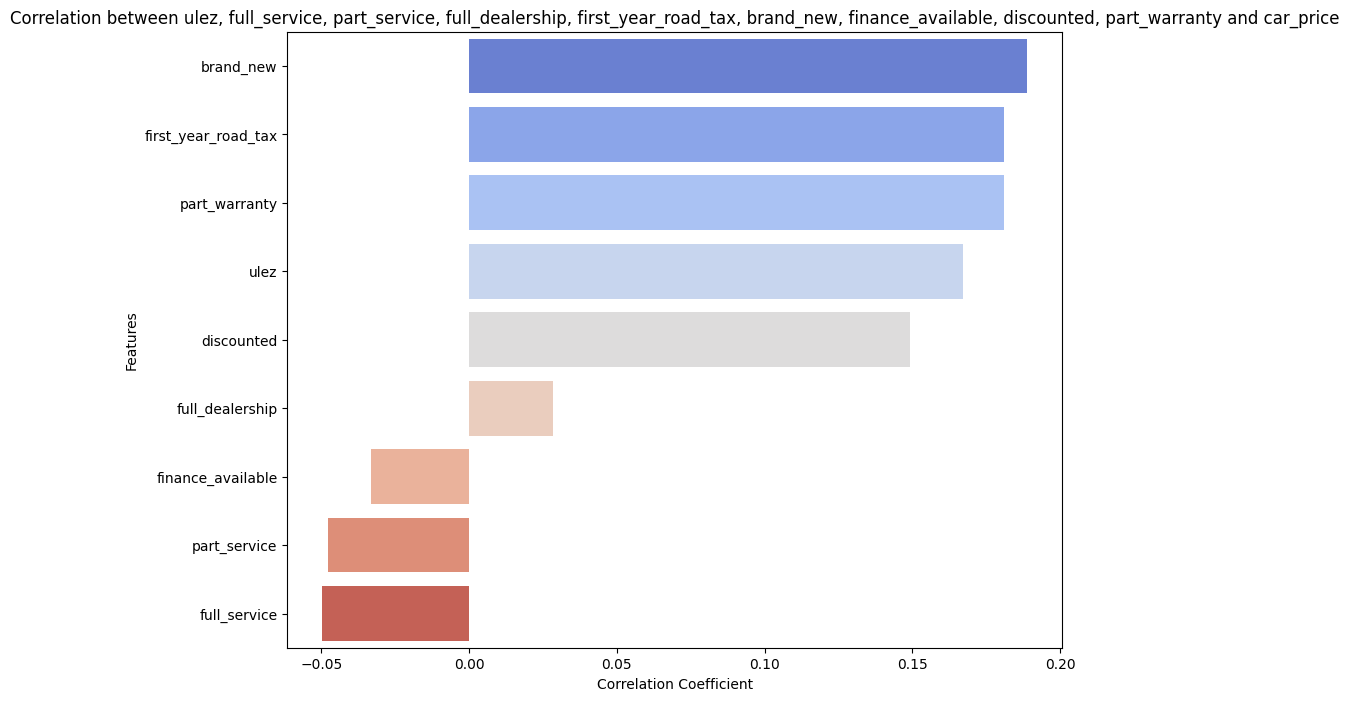

In [ ]:
binary_columns = ['ulez', 'full_service', 'part_service',
                    'full_dealership', 'first_year_road_tax', 'brand_new',
                    'finance_available', 'discounted', 'part_warranty']
target_column = 'car_price'
correlations = df[binary_columns + [target_column]].corr()[target_column].sort_values(ascending=False)

    # Filter out the target column itself
correlations = correlations.drop(target_column)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title(f'Correlation between {", ".join(binary_columns)} and {target_column}')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()



As we can see, the correlation with car price is not very high, but we have gained valuable insights from some of the binary features.

The low correlation does not necessarily mean these features are not useful for predicting the target variable. It is possible that, when combined with other features, they provide significant information.

For this reason, I will retain all of these features.

The only other step I would take is to convert these numerical features into categorical features, as they are currently represented numerically but may better serve the model as categories.

In [ ]:
boolean_features = ['ulez', 'full_service', 'part_service',
                    'full_dealership', 'first_year_road_tax', 'brand_new',
                    'finance_available', 'discounted', 'part_warranty']

df[boolean_features] = df[boolean_features].astype(bool)

# Handling Numeric Features

Let's examine the numeric features present in the dataset.

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
print(numeric_columns)

['car_price', 'year', 'miles', 'engine_vol', 'engine_size']


As we observed earlier, the "miles" feature has a significant number of missing values—around 6%.

To reduce this percentage, I will first check if the car is brand new. If it is, the "miles" value should be 0, so I will fill those missing cells with 0. For the remaining missing values, I will delete the rows, as the number of rows with null values is relatively small.

Before:

In [ ]:
missing_percentage = df['miles'].isna().mean() * 100
missing_percentage

6.689816030975511

After:

In [ ]:
df.loc[df['brand_new'] == True, 'miles'] = df.loc[df['brand_new'] == True, 'miles'].fillna(0)
missing_percentage = df['miles'].isna().mean() * 100
missing_percentage

0.06646685881779406

As we can see, the large number of missing values is due to the cars being new. I have updated those missing values to 0. Now, I will drop the rows that still have null values.

In [ ]:
df = df.dropna(subset=['miles'])


Lets handle first the remain of the missing values:

In [ ]:
missing_percentages = df[['car_price', 'year', 'miles', 'engine_vol', 'engine_size']].isnull().mean() * 100
missing_percentages

,0
car_price,0.000000
year,5.877060
miles,0.000000
engine_vol,1.884806
engine_size,0.512893


To fill the missing values in the "year" feature, I will use the following approach:

1. For rows where the "brand_new" cell is true, I will fill the missing "year" value with the maximum year present in the dataset.

2. For other missing values, I will apply a clustering approach:

Create 10 clusters for the "miles" feature (e.g., 0-10%, 10-20%, etc.).
Calculate the mean "year" for each cluster.
Fill the missing "year" values based on the mean "year" of their respective "miles" cluster.
This approach should help fill in the missing year values in a way that preserves the relationship with other features.

In [ ]:
def fill_years(df_copy):
    max_year = df_copy['year'].max()
    df_copy.loc[df_copy['brand_new'] == True, 'year'] = max_year
    missing_percentages = df[['year']].isnull().mean() * 100
    print(f"missing precentage after filling the year value with max value: {missing_percentages}")

    num_bins = 10
    mile_min, mile_max = df_copy['miles'].min(), df_copy['miles'].max()
    bin_edges = np.linspace(mile_min, mile_max, num_bins)  # Create 10 equal-width bins

    df_copy['mile_bin'] = pd.cut(df_copy['miles'], bins=bin_edges, labels=False, include_lowest=True).astype(int) + 1
    mile_bin_medians = df_copy.dropna(subset=['year']).groupby('mile_bin')['year'].median().to_dict()

    def fill_missing_year(row):
        if pd.isna(row['year']):
            # Get the median year based on the mile_bin of the row
            median_year = mile_bin_medians.get(row['mile_bin'])
            if median_year:
                return median_year
        return row['year']

    df_copy['year'] = df_copy.apply(fill_missing_year, axis=1)
    df_copy['year'] = df_copy['year'].round().astype('Int64')  # Keeps NaNs
    df_copy.drop(columns=['mile_bin'], inplace=True)
fill_years(df)
missing_percentages = df[['year']].isnull().mean() * 100
print(f"missing precentage after filling the year value: {missing_percentages}")


missing precentage after filling the year value with max value: year    0.017117
dtype: float64
missing precentage after filling the year value: year    0.0
dtype: float64


**Correlation between features:**

As part of the pre-processing process, it is important to understand which features are highly correlated. If we observe strong correlations, we may consider removing one of the features to avoid multicollinearity. Additionally, we will look for features that have a significant impact on the target variable, which is the car price, to ensure the model's predictive power is optimized.

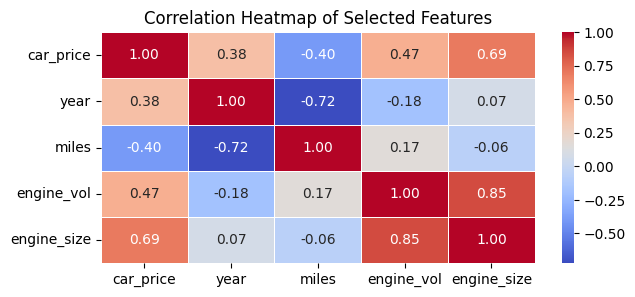

In [ ]:
selected_features = ['car_price', 'year', 'miles', 'engine_vol', 'engine_size']
corr_sample = df[selected_features].corr(numeric_only=True)

plt.figure(figsize=(7, 3))
sns.heatmap(corr_sample, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

From the correlation matrix, we can observe that there is a high correlation (as expected) between the "miles," "year," "engine_size," "engine_vol," and the target feature—car price. This suggests that these features are likely to have a significant impact on the car price, and we may want to focus on them during modeling.

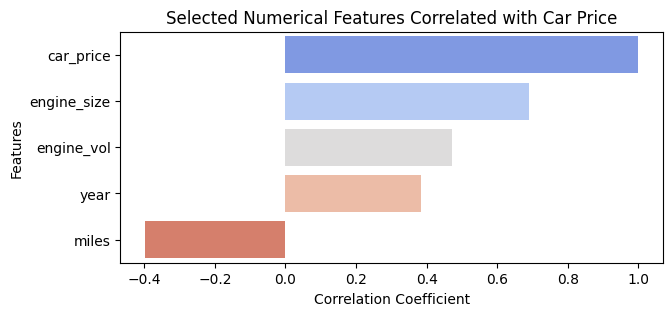

In [ ]:
selected_features = ['car_price', 'year', 'miles', 'engine_vol', 'engine_size']
numeric_columns = df[selected_features]

correlation_with_car_price = numeric_columns.corr()['car_price'].sort_values(ascending=False)

plt.figure(figsize=(7, 3))
sns.barplot(x=correlation_with_car_price.values, y=correlation_with_car_price.index, palette='coolwarm')
plt.title('Selected Numerical Features Correlated with Car Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

From these plots, I can learn a lot. It's clear that the numerical features in our dataset have a significant influence on the target feature—car price.

Another insight from the first plot is that "engine_size" and "engine_vol" have a very high correlation with each other. After reviewing the meanings of both features, I understand that they essentially convey the same information.

To avoid overfitting, the best approach would be to remove one of these features. I will drop the "engine_vol" feature, as it has a lower correlation with the car price feature.

In [ ]:
df = df.drop(columns=['engine_vol'])

CORRELATION - END

# **Handling outliers and Normal distribution:**


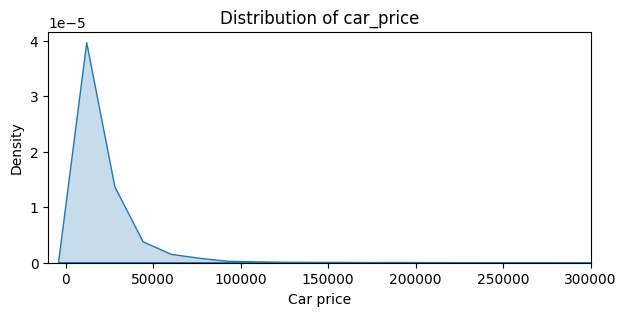

In [ ]:
plt.figure(figsize=(7, 3))
sns.kdeplot(df['car_price'], fill = True)
plt.xlabel('Car price')
plt.ylabel('Density')
plt.title('Distribution of car_price')
plt.xlim([-10000,300000])
plt.show()

As shown in the visual representation (the KDE plot, which reveals a long tail and numerous outliers in the higher price range) as well as the results from the DataFrame's describe function, the distribution of the "car_price" parameter does not follow a normal distribution.

This presents a challenge, as many straightforward models assume normality. To address this in the pre-processing step, we will handle the outliers by removing them and then re-evaluate the distribution to observe any changes in its characteristics.

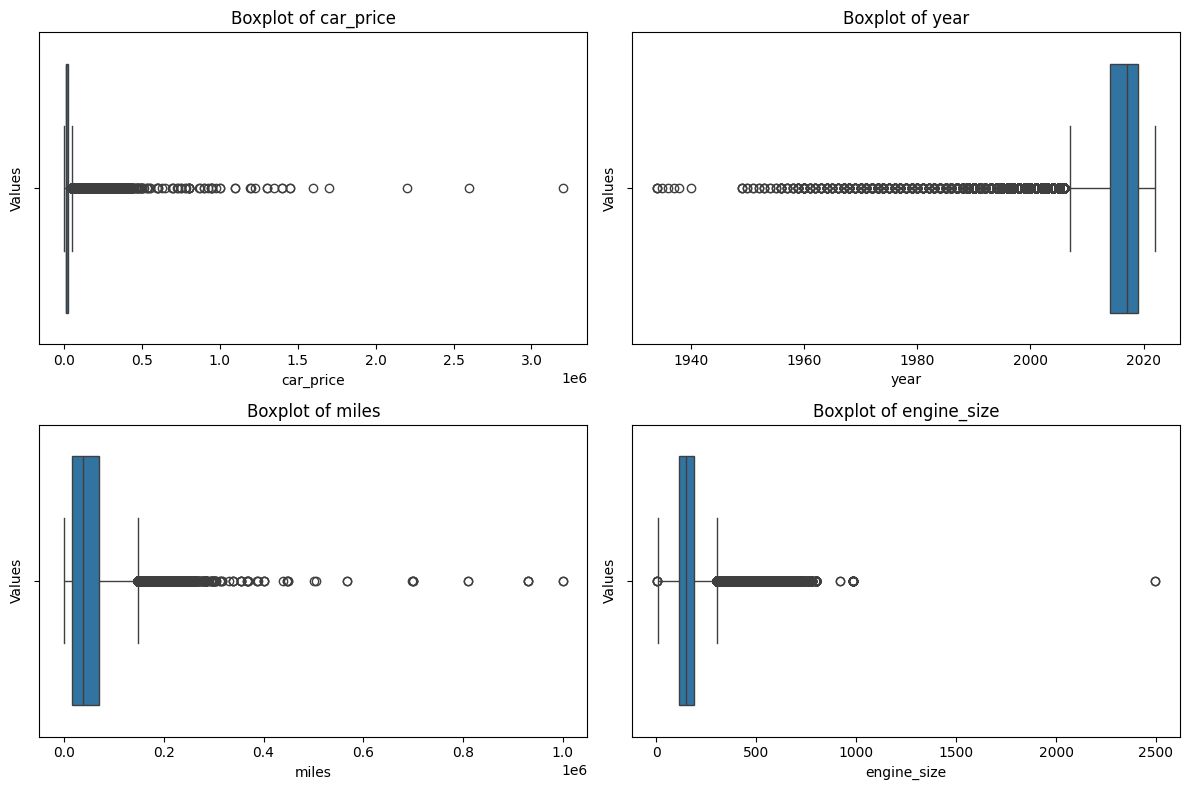

In [ ]:
# Create a figure with subplots
numerical_col = list(df.describe().columns)
num_cols = len(numerical_col)
rows = (num_cols + 1) // 2
plt.figure(figsize=(12, rows * 4))

for i, col in enumerate(numerical_col, start=1):
    plt.subplot(rows, 2, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Values', fontsize=10)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


As shown in the boxplot distribution, it appears that there are significant issues with outliers in the data. I will proceed with further processing to handle these outliers and ensure the data is ready for modeling.

In [ ]:
def evaluate_outlier_removal(df, multipliers=[1.5, 2, 2.5, 3, 3.5, 4]):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    initial_rows = len(df)

    results = []

    for multiplier in multipliers:
        df_filtered = df.copy()

        for col in numerical_cols:
            Q1 = df_filtered[col].quantile(0.25)
            Q3 = df_filtered[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]

        final_rows = len(df_filtered)
        rows_dropped = initial_rows - final_rows
        percentage_dropped = (rows_dropped / initial_rows) * 100

        # Compute skewness & kurtosis before and after
        original_skewness = df[numerical_cols].apply(skew).mean()
        filtered_skewness = df_filtered[numerical_cols].apply(skew).mean()

        original_kurtosis = df[numerical_cols].apply(kurtosis).mean()
        filtered_kurtosis = df_filtered[numerical_cols].apply(kurtosis).mean()

        results.append({
            "Multiplier": multiplier,
            "Rows Dropped (%)": f"{percentage_dropped:.2f}%",
            "Skewness Before": f"{original_skewness:.2f}",
            "Skewness After": f"{filtered_skewness:.2f}",
            "Kurtosis Before": f"{original_kurtosis:.2f}",
            "Kurtosis After": f"{filtered_kurtosis:.2f}"
        })

    return pd.DataFrame(results)


result_df = evaluate_outlier_removal(df)
result_df


,Multiplier,Rows Dropped (%),Skewness Before,Skewness After,Kurtosis Before,Kurtosis After
0,1.5,15.03%,5.25,0.41,400.77,-0.04
1,2.0,9.14%,5.25,0.50,400.77,0.42
2,2.5,6.47%,5.25,0.59,400.77,0.84
3,3.0,4.66%,5.25,0.68,400.77,1.31
4,3.5,3.54%,5.25,0.75,400.77,1.69
5,4.0,2.86%,5.25,0.79,400.77,2.00


The multiplier has been adjusted to the data. Initially, a multiplier of 1.5 was chosen, which resulted in 15.03% of the data being deleted. To improve this, I have increased the multiplier to 4.0.

If the results are not satisfactory, I will apply a more refined filter to better handle the outliers.

In [ ]:
# Remove outliers
numerical_col = list(df.describe().columns)
df_original = df.copy()
multiplier = 4
for col in numerical_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Store the final number of rows
final_rows = len(df)
initial_rows = len(df_original)

# Calculate the percentage of rows dropped
rows_dropped = initial_rows - final_rows
percentage_dropped = (rows_dropped / initial_rows) * 100

# Print results
print(f"Initial rows: {initial_rows}")
print(f"Final rows: {final_rows}")
print(f"Rows dropped: {rows_dropped}")
print(f"Percentage of rows dropped: {percentage_dropped:.2f}%")

Initial rows: 817909
Final rows: 794539
Rows dropped: 23370
Percentage of rows dropped: 2.86%


I plotted the boxplot again to check if, after removing the outliers, the distribution of car prices is more balanced and equal.

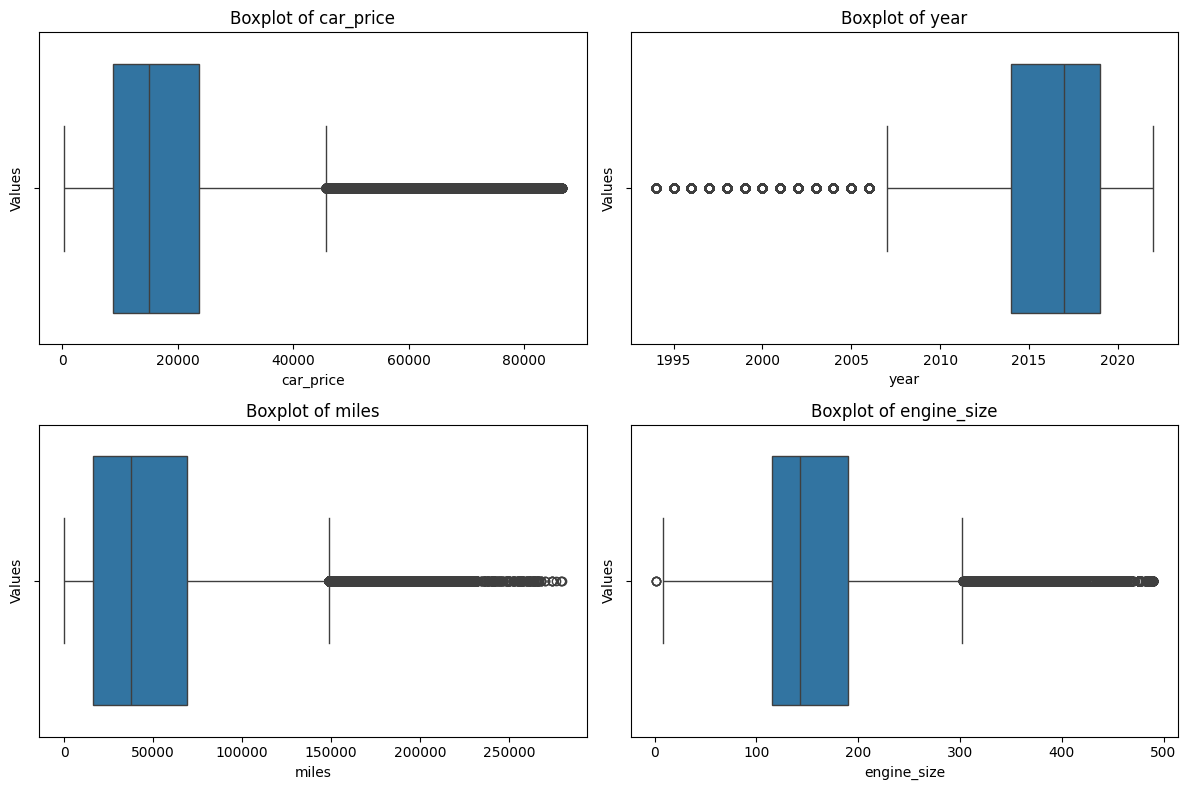

In [ ]:
num_cols = len(numerical_col)
rows = (num_cols + 1) // 2
plt.figure(figsize=(12, rows * 4))

for i, col in enumerate(numerical_col, start=1):
    plt.subplot(rows, 2, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Values', fontsize=10)

plt.tight_layout()


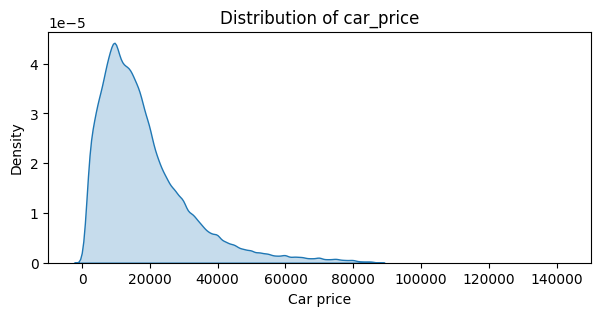

In [ ]:
plt.figure(figsize=(7, 3))
sns.kdeplot(df['car_price'], fill = True)
plt.xlabel('Car price')
plt.ylabel('Density')
plt.title('Distribution of car_price')
plt.xlim([-10000,150000])
plt.show()

The process I followed here aims to minimize the skew while retaining as much data as possible.

The trade-off lies between deleting data and achieving a more normal distribution. While using a different multiplier could bring us closer to a normal distribution, the results so far look good with the current multiplier. I will adjust it further based on the results of the models.

# **Encoding the categorial data:**

I will encode all the categorical columns as follows:

**One-Hot Encoding:**

The features "body_type," "transmission," "fuel_type," and "make" will be encoded using one-hot encoding, creating separate columns for each category.

**Hash Encoding:**

The "model" feature will be encoded using hash encoding. Hash encoding transforms the categorical feature into a fixed number of new columns based on hash values. Each new column represents a portion of the hashed information, which reduces the risk of collisions. The number of columns is controlled by the n_features parameter.
To avoid excessive dimensionality while preserving accuracy, I will set n_features to at least log2(number of unique values) or higher. Since we have around 1300 unique values for the "model" feature, this means n_features should be approximately 11 or more (log2(1300) ≈ 11).

In [ ]:
df = pd.get_dummies(df, columns=['body_type', 'transmission', 'feul_type', 'make'])
df

,model,car_price,year,miles,engine_size,ulez,full_service,part_service,part_warranty,full_dealership,...,make_Ssangyong,make_Subaru,make_Suzuki,make_TVR,make_Tesla,make_Toyota,make_Vauxhall,make_Volkswagen,make_Volvo,make_Westfield
8,124 Spider,24275.0,2019,10313.0,169.40814,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,124 Spider,24275.0,2019,10313.0,169.40814,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,124 Spider,25000.0,2018,11500.0,170.00000,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11,124 Spider,15649.0,2018,28692.0,170.42256,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,124 Spider,15995.0,2017,44000.0,170.00000,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818438,XC90,82460.0,2022,0.0,455.00000,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
818439,XC90,82640.0,2022,0.0,455.00000,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
818440,XC90,82640.0,2022,0.0,455.00000,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
818441,XC90,82640.0,2022,0.0,455.00000,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


# **Part 2: Naive models**

In [ ]:
!pip install category_encoders
import category_encoders as ce

# Define the number of hash bits (e.g., 10 will create 2^10 = 1024 features)
hash_encoder = ce.HashingEncoder(cols=['model'], n_components=10)

# Fit and transform
df_transformed = hash_encoder.fit_transform(df)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
df_transformed

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,make_Ssangyong,make_Subaru,make_Suzuki,make_TVR,make_Tesla,make_Toyota,make_Vauxhall,make_Volkswagen,make_Volvo,make_Westfield
8,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
9,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
10,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
11,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
12,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818438,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
818439,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
818440,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
818441,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
df = df_transformed

First, we will split the data into training and testing sets. Then, we will explore a few models that are suited for regression tasks: XGBoost, Gradient Boosting, KNN, and Linear Regression and Random Forest..

**Steps:**
Split the Data: Divide the data into training and testing sets to evaluate model performance.

Models to Test:

**XGBoost:** A powerful gradient boosting model known for its speed and performance.

**Gradient Boosting:** Another gradient boosting method, often providing robust results.

**Random Forest**: A robust ensemble method that uses multiple decision trees to reduce variance and overfitting.

**Linear Regression:** A simple but often effective model for regression tasks.

**Cross-Validation**: We will conduct 10-fold cross-validation to ensure the models generalize well on unseen data.

Data Normalization: Normalize the data within each fold to ensure proper scaling, as some models (like KNN) are sensitive to the scale of the data.

**Evaluation Metrics:**
Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values.
R²: Indicates how well the model explains the variance in the target variable.
We will run all models with the above steps and then evaluate their performance using MSE and R² to determine the best-performing model.

In [14]:
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train)
    return model

def evaluate_model_kfold(model, x, y, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    train_r2_scores, test_r2_scores = [], []
    train_mse_scores, test_mse_scores = [], []
    fold = 0
    for train_index, test_index in kf.split(x):
        x_train, x_valid = x.iloc[train_index], x.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_valid_scaled = scaler.transform(x_valid)

        trained_model = train_model(model, x_train_scaled, y_train)

        y_train_pred = trained_model.predict(x_train_scaled)
        y_valid_pred = trained_model.predict(x_valid_scaled)


        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_valid, y_valid_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_valid, y_valid_pred)

        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
        train_mse_scores.append(train_mse)
        test_mse_scores.append(test_mse)
        print(f"Fold {fold + 1}: Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
        fold += 1


    return {
        "Train R^2 AVG[SD]": f"{np.mean(train_r2_scores):.4f}[{np.std(train_r2_scores):.4f}]",
        "Test R^2 AVG[SD]": f"{np.mean(test_r2_scores):.4f}[{np.std(test_r2_scores):.4f}]",
        "Train MSE AVG[SD]": f"{np.mean(train_mse_scores):.4f}[{np.std(train_mse_scores):.4f}]",
        "Test MSE AVG[SD]": f"{np.mean(test_mse_scores):.4f}[{np.std(test_mse_scores):.4f}]"
    }

def evaluate_all_models(models, model_names, x, y, k=10):
    results = []
    for model_name, model in zip(model_names, models):
        print(f"Evaluating {model_name}...")
        scores = evaluate_model_kfold(model, x, y, k)
        scores["Model"] = model_name
        results.append(scores)
    return pd.DataFrame(results)

def split_data(df, goal_feature, columns=None):
  df_copy = df.copy()
  df_copy = df_copy.dropna(subset=[goal_feature])
  if columns is None:
      x = df_copy.drop(columns=[goal_feature])
  else:
      x = df_copy[columns]
  y = df_copy[goal_feature]
  return x,y

if not SKIP_FINFING_BEST_MODEL:
  model_names = ['XGBoost', 'Random Forest', 'Gradient Boosting', 'Linear Regression']
  models = [
      XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101, reg_alpha=10, reg_lambda=10),
      RandomForestRegressor(n_estimators=50, max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', bootstrap=True, n_jobs=-1, random_state=42),
      GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
      LinearRegression()
  ]
  x, y = split_data(df, 'car_price')
  results_df = evaluate_all_models(models, model_names, x, y)
  print("\nFinal Results:")
  print(results_df)
else:
  with open("Final_result.txt", "r", encoding="utf-8") as file:
    content = file.read()
    print(content)


Final Results:
  Train R^2 AVG[SD] Test R^2 AVG[SD]           Train MSE AVG[SD]  \
0    0.9620[0.0004]   0.9614[0.0005]    7025555.3240[75402.0598]   
1    0.9288[0.0018]   0.9273[0.0015]  13160338.9633[333162.6099]   
2    0.9502[0.0004]   0.9497[0.0007]    9210265.5479[71871.7540]   
3    0.8419[0.0001]   0.8418[0.0009]   29231613.4516[32674.4775]   

             Test MSE AVG[SD]              Model  
0   7130061.0275[108704.8917]            XGBoost  
1  13444369.0068[260831.0960]      Random Forest  
2   9304252.8128[138849.9224]  Gradient Boosting  
3  29247684.6831[291959.7526]  Linear Regression  


As we can see, I found a very good models that predict the car price in high precentage. I will focus on finding the best hyperparameters for XGBoost to improve its performance.

# **Optimizing Hyperparameters**
As seen before, my current best score achieved by XGBoost.

Let's try to improve that by optimizing the hyperparameters of our chosen model.

In this code, I’m tuning the hyperparameters of my XGBoost regression model to get the best performance. I’ve set up a grid of hyperparameters to test, like the number of estimators, learning rate, tree depth, and regularization terms. I’m using GridSearchCV to perform a cross-validation grid search, which tests all possible combinations of these parameters. It evaluates the models using 5-fold cross-validation, with the R² score as the metric to assess performance. At the end, I print out the best combination of parameters and the highest R² score to find the optimal setup for my model.

In [10]:
if not SKIP_FINDING_HYPER_PARAMTER:
  # Define hyperparameter grid
  param_grid = {
      'n_estimators': [300,500,700],
      'learning_rate': [0.01, 0.1, 0.2],
      'max_depth': [5,9,11,13],
      'random_state': [101],
      'reg_alpha':[1, 5, 10],
      'reg_lambda': [10]

  }

  xgb = XGBRegressor(random_state=101)

  grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
  x, y = split_data(df, 'car_price')
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  grid_search.fit(x, y)

  print("Best parameters:", grid_search.best_params_)
  print("Best R^2 score:", grid_search.best_score_)
else:
    with open("Best_parameters_XGBRegressor.txt", "r", encoding="utf-8") as file:
      content = file.read()
      print(content)

Best parameters: XGBRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=9,
    random_state=101,
    reg_alpha=10,
    reg_lambda=10
)

Best R^2 score: 0.97988


This code is taking a long time to run.

To address this, I ran the grid search separately. I used it to find the best parameters that improved my model without overfitting.

The optimal parameters are:

XGBRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=9,
    random_state=101,
    reg_alpha=10,
    reg_lambda=10
)
I will use these parameters to evaluate my model.

# **Num owner expirience**

The num_owner column represents the number of previous owners for each car. In real-world data, this feature significantly impacts car prices—generally, the more owners a car has had, the lower its price.

**Problem Statement**
Currently, 45% of the values in the num_owner column are missing. To address this, I plan to use the miles and year columns to predict the missing values.

**Approach**

I will experiment with:

**Train a regression model** (Linear Regression, XGBoost, or Gradient Boosting)

to predict num_owner based on available features.

**Evaluation Strategy**

After filling in the missing values using both methods, I will retrain my model and evaluate whether the prediction results improve.
One important factor affecting num_owner is the car price, but since it is the target variable, I cannot use it in the prediction process—doing so would lead to **overfitting**.

By comparing both approaches, I aim to determine which method better improves the overall model performance.

**I saved the num_owners column at the begining of the colab.**

# **Regression**

In [ ]:
df_with_num_owner = df.copy()
df_with_num_owner = df_with_num_owner.join(num_owners_saved_df, how='left')
df_with_num_owner

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,make_Subaru,make_Suzuki,make_TVR,make_Tesla,make_Toyota,make_Vauxhall,make_Volkswagen,make_Volvo,make_Westfield,num_owner
8,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,2.0
9,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,2.0
10,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,2.0
11,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,NaN
12,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818438,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,NaN
818439,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,NaN
818440,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,NaN
818441,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,NaN


In [13]:
if not SKIP_RUN_EXPIRIMENT:
  model_names = ['XGBoost', 'Linear Regression']
  models = [
      XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101, reg_alpha=10, reg_lambda=10),
      LinearRegression()
  ]
  scaler = StandardScaler()
  x, y = split_data(df_with_num_owner, 'num_owner', ['year', 'miles'])

  # Run evaluation
  results_df = evaluate_all_models(models, model_names, x, y)
  print("\nFinal Results:")
  print(results_df)
else:
  with open("Expiriment_result.txt", "r", encoding="utf-8") as file:
      content = file.read()
      print(content)


Evaluating XGBoost...
Fold 1: Train R^2: 0.3925, Test R^2: 0.3872, Train MSE: 0.9521, Test MSE: 0.9730
Fold 2: Train R^2: 0.3926, Test R^2: 0.3866, Train MSE: 0.9525, Test MSE: 0.9684
Fold 3: Train R^2: 0.3922, Test R^2: 0.3912, Train MSE: 0.9542, Test MSE: 0.9512
Fold 4: Train R^2: 0.3931, Test R^2: 0.3841, Train MSE: 0.9526, Test MSE: 0.9640
Fold 5: Train R^2: 0.3929, Test R^2: 0.3829, Train MSE: 0.9519, Test MSE: 0.9759
Fold 6: Train R^2: 0.3925, Test R^2: 0.3888, Train MSE: 0.9536, Test MSE: 0.9565
Fold 7: Train R^2: 0.3928, Test R^2: 0.3842, Train MSE: 0.9532, Test MSE: 0.9628
Fold 8: Train R^2: 0.3921, Test R^2: 0.3933, Train MSE: 0.9560, Test MSE: 0.9340
Fold 9: Train R^2: 0.3925, Test R^2: 0.3858, Train MSE: 0.9523, Test MSE: 0.9726
Fold 10: Train R^2: 0.3923, Test R^2: 0.3899, Train MSE: 0.9539, Test MSE: 0.9549
Evaluating Linear Regression...
Fold 1: Train R^2: 0.3656, Test R^2: 0.3655, Train MSE: 0.9942, Test MSE: 1.0073
Fold 2: Train R^2: 0.3654, Test R^2: 0.3670, Train MSE

The train and test R² values are close, suggesting no major overfitting.
The test R² (~0.3874) is relatively low, meaning the model is explaining only ~38.74% of the variance, indicating room for improvement.
The low standard deviations suggest that the model is performing consistently across different folds.

After I analyze the data and saw the result, I choosed the model: linear regression and now I will fill the num_owner column with the data that my model predict.

**Discussion on the Results**

As we can see from the results, the number of owners experiment did not succeed. The model was unable to accurately fill the num_owner column based solely on the miles and year columns.

The conclusion is to continue working with the original dataset rather than the num_owner_df, as the additional feature did not contribute meaningfully to the prediction task.

# **Model Performence Analysis**

After analyzing and optimizing our data and model, let's dive deeper and examine how our model behaves using SHAP (SHapley Additive exPlanations).

This method will help us understand the impact of each feature on the model's predictions, providing insights into the relative importance and effect of each variable within the model.

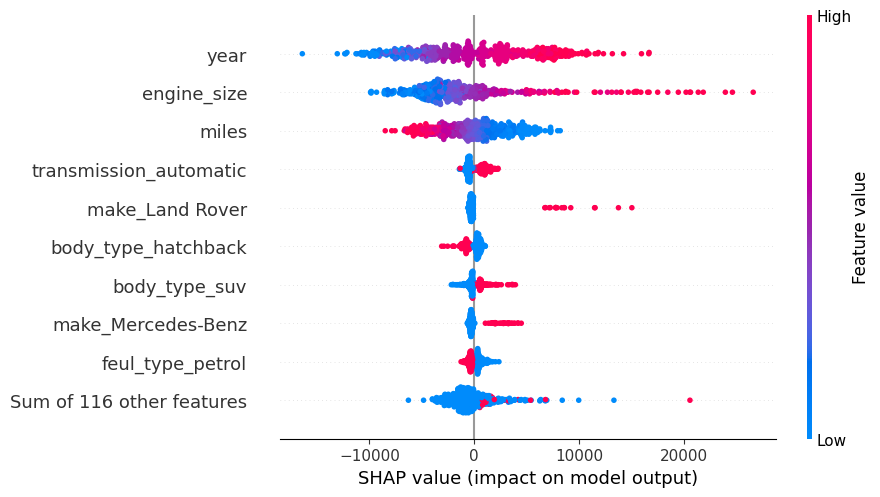

In [ ]:
X = df.drop(columns=['car_price'])
y = df['car_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_test, y_train, y_test = [x.reset_index(drop=True) for x in [X_train, X_test, y_train, y_test]]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled training data into a DataFrame (for SHAP)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

model = XGBRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=9,
    random_state=101,
    reg_alpha=10,
    reg_lambda=10
)

model.fit(X_train_scaled_df, y_train)
y_pred = model.predict(X_test_scaled)

shap_sample = X_train_scaled_df.sample(500, random_state=42)

explainer = shap.Explainer(model, X_train_scaled_df)
shap_values = explainer(shap_sample)

shap.plots.beeswarm(shap_values)


The x-axis represents the SHAP value (impact on model output). Positive values indicate a higher predicted price, while negative values indicate a lower predicted price.
The y-axis lists the features ranked by importance (top to bottom).
Each dot represents a data point, and its color indicates the feature value (red = high, blue = low).

**Year**

A higher year (newer cars, red) increases car price (positive SHAP values).
Older cars (blue) reduce the price (negative SHAP values).

**Engine Size**

Larger engines (red) increase the price.
Smaller engines (blue) decrease the price.

**Miles**

Higher mileage (red) decreases the price (negative SHAP values).
Low mileage (blue) increases the price (positive SHAP values).


**Transmission_Automatic**

Automatic transmission (red) generally increases the price.
Manual transmission (blue) tends to lower the price.

**Make_Land Rover**

Being a Land Rover (red) significantly increases the price.
Other makes (blue) reduce the price.

**Body Type - Hatchback**

Hatchback cars (red) tend to reduce the price.
Other body types (blue) might have a neutral or higher effect.

**Fuel Type - Petrol**

Petrol cars (red) slightly increase the price.
Other fuel types (blue) show a minor negative impact.

**Body Type - SUV**

SUVs (red) increase the price.
Other body types (blue) have a neutral or lower impact.

**Make - Mercedes-Benz**

Being a Mercedes-Benz (red) increases the price significantly.
Other brands (blue) have a lower price impact.

**Sum of 106 other features**

These features have less impact individually but collectively influence the price prediction.

for conclusion, Newer cars, SUVs, and premium brands (Land Rover, Mercedes-Benz) increase price.
Higher mileage, older cars, and hatchbacks lower price.
Transmission type and fuel type have moderate effects.

I did not expect engenine size to impact so much on the model. I thought it will be, the more the miles and the type of the car - luxury cars as mercedes and BMW.

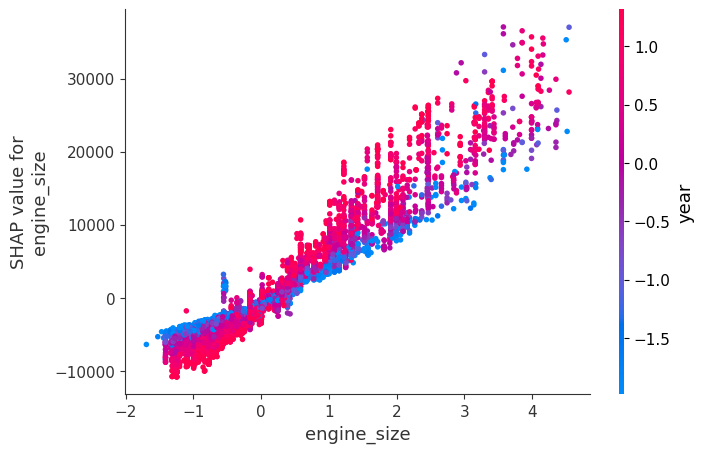

In [ ]:
sample_size = 10000  # Adjust based on performance needs
X_sample = X_train_scaled_df.sample(sample_size, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

shap.dependence_plot("engine_size", shap_values, X_sample)

 This SHAP dependence plot illustrates how engine_size influences the model's predictions. As engine_size increases, SHAP values also rise, indicating that larger engines contribute to higher predicted values. The color gradient represents the year feature, showing its interaction with engine_size, where the transition from blue to red suggests that the impact of engine size varies depending on the year. Additionally, there is noticeable variance in SHAP values for larger engines, implying that other factors also influence predictions. The increasing spread of SHAP values at higher engine sizes further highlights this variability. This trend is reasonable because newer vehicles (higher year values) often have larger engines due to technological advancements, evolving consumer preferences, and regulatory changes that impact engine design and performance.

# **Error Analysis**


Columns with True values:
['col_2', 'ulez', 'brand_new', 'body_type_camper', 'transmission_automatic', 'feul_type_diesel', 'make_Volkswagen']
Car details with the maximum positive price difference:
 col_0                  0
col_1                  0
col_2                  1
col_3                  0
col_4                  0
                   ...  
make_Toyota        False
make_Vauxhall      False
make_Volkswagen     True
make_Volvo         False
make_Westfield     False
Name: 28623, Length: 125, dtype: object
Real Price: 50388.0
Predicted Price: 80050.25
Difference: 29662.25
Miles: 0.0
Year: 2022
Engine Size: 152.163


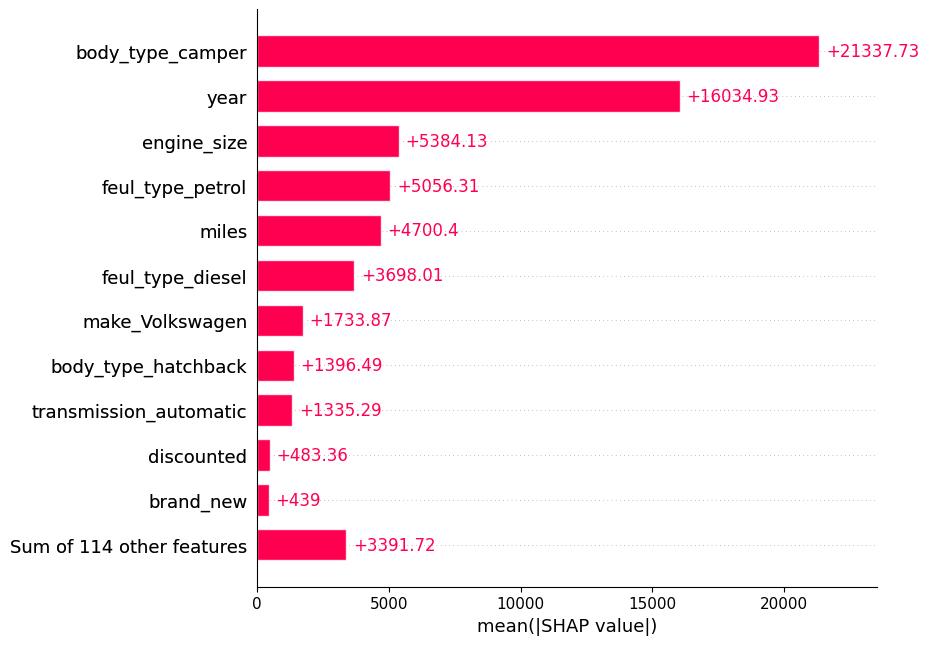

In [ ]:
pred_diff = y_pred - y_test

max_positive_diff_index = np.argmax(pred_diff)

max_positive_diff_car = X_test.iloc[max_positive_diff_index]

# Find the columns with True values in the closest_diff_car row
true_columns = max_positive_diff_car[max_positive_diff_car == True].index.tolist()

# Print the names of the columns with True values
print("Columns with True values:")
print(true_columns)


real_price = y_test.iloc[max_positive_diff_index]
predicted_price = y_pred[max_positive_diff_index]
difference = pred_diff[max_positive_diff_index]

print("Car details with the maximum positive price difference:\n", max_positive_diff_car)
print(f"Real Price: {real_price}")
print(f"Predicted Price: {predicted_price}")
print(f"Difference: {difference}")



miles = max_positive_diff_car['miles']
year = max_positive_diff_car['year']
engine_size = max_positive_diff_car['engine_size']

print(f"Miles: {miles}")
print(f"Year: {year}")
print(f"Engine Size: {engine_size}")

pos_car_idx = X_test.index[max_positive_diff_index]

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

single_car = X_test_scaled_df.iloc[[max_positive_diff_index]]

explainer = shap.TreeExplainer(model)
shap_values_single = explainer(single_car)

shap.plots.bar(shap_values_single, max_display=12)


**Worse prediction example:**

The significant difference between the predicted price (80050.25) and the actual price (29662.25) suggests that the model has overestimated the car's value by approximately 29,662.25.

The data presented indicates that the car is a large van powered by a diesel engine, specifically a Volkswagen, with no mileage information. It has a relatively large engine and overall good specifications.

The model likely overestimated the price due to several high-value features influencing the prediction. These include the car being a Volkswagen, which is an expensive brand, having a relatively large engine that further increases the price, and being a new car, which also drives the price up.

This car likely represents an outlier case, as it's difficult to estimate the prices of van-type vehicles. Out of the 800,000 rows in our dataset, only 400 are of the van type.

Therefore, the model probably overestimated the value of this vehicle due to the lack of sufficient data for this category of car.




# **Best predicted example:**

Columns with True values:
['col_5', 'ulez', 'finance_available', 'body_type_suv', 'transmission_manual', 'feul_type_petrol', 'make_MINI']
Car details with the closest predicted price:
 col_0                  0
col_1                  0
col_2                  0
col_3                  0
col_4                  0
                   ...  
make_Toyota        False
make_Vauxhall      False
make_Volkswagen    False
make_Volvo         False
make_Westfield     False
Name: 16318, Length: 125, dtype: object
Real Price: 9995.0
Predicted Price: 9995.0009765625
Difference: 0.0009765625
Miles: 38000.0
Year: 2013
Engine Size: 122.0


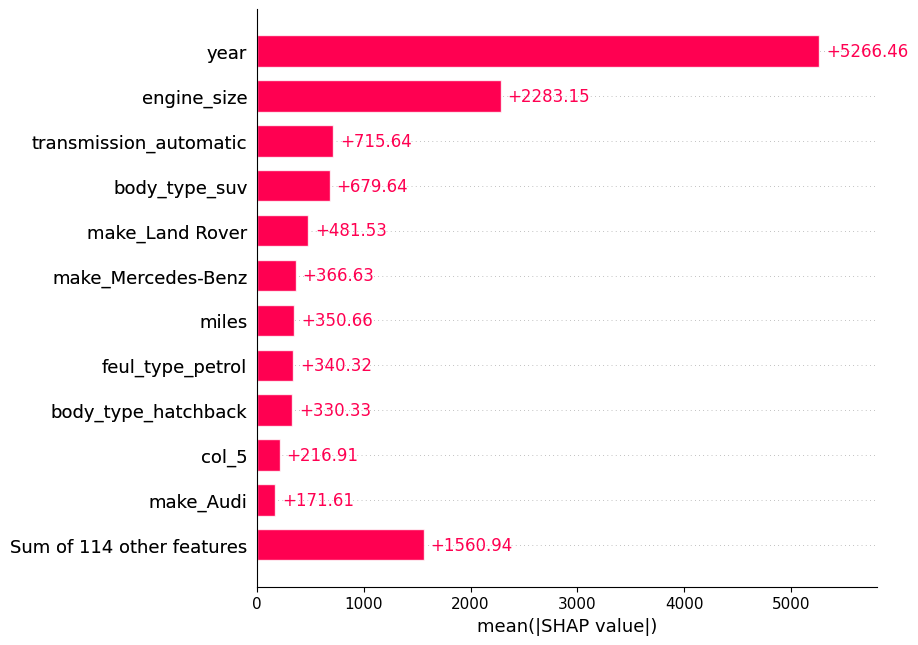

In [ ]:
pred_diff = y_pred - y_test

closest_diff_index = np.argmin(np.abs(pred_diff))

closest_diff_car = X_test.iloc[closest_diff_index]

# Find the columns with True values in the closest_diff_car row
true_columns = closest_diff_car[closest_diff_car == True].index.tolist()

# Print the names of the columns with True values
print("Columns with True values:")
print(true_columns)

real_price = y_test.iloc[closest_diff_index]
predicted_price = y_pred[closest_diff_index]
difference = pred_diff[closest_diff_index]

print("Car details with the closest predicted price:\n", closest_diff_car)
print(f"Real Price: {real_price}")
print(f"Predicted Price: {predicted_price}")
print(f"Difference: {difference}")

miles = closest_diff_car['miles']
year = closest_diff_car['year']
engine_size = closest_diff_car['engine_size']

print(f"Miles: {miles}")
print(f"Year: {year}")
print(f"Engine Size: {engine_size}")

pos_car_idx = X_test.index[closest_diff_index]

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

single_car = X_test_scaled_df.iloc[[closest_diff_index]]

explainer = shap.TreeExplainer(model)
shap_values_single = explainer(single_car)

shap.plots.bar(shap_values_single, max_display=12)

The make of the car is Mini.

Miles: 38,000.0

Year: 2013

Engine Size: 122.0

As I mentioned earlier, engine size doesn't have much impact in this case because the engine is small. Additionally, the car's year doesn't affect the price much either, as the car is 9 years old.

Mini cars are generally inexpensive, so given these features, the model predicts a low price, which aligns with the actual car price.

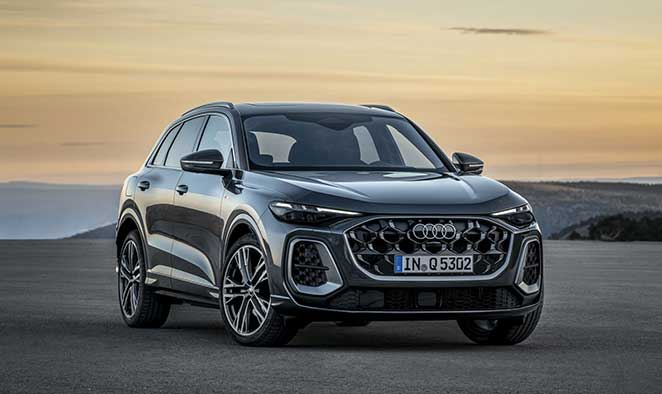

# **Audi example:**

Car details with 'make_Volvo' = True and price > 20,000:
col_0                  0
col_1                  0
col_2                  0
col_3                  0
col_4                  1
                   ...  
make_Toyota        False
make_Vauxhall      False
make_Volkswagen    False
make_Volvo         False
make_Westfield     False
Name: 5994, Length: 125, dtype: object
Real Price: 47499.0
Predicted Price: 45276.51953125
Difference: -2222.48046875
Miles: 0.0
Year: 2022
Engine Size: 190.0


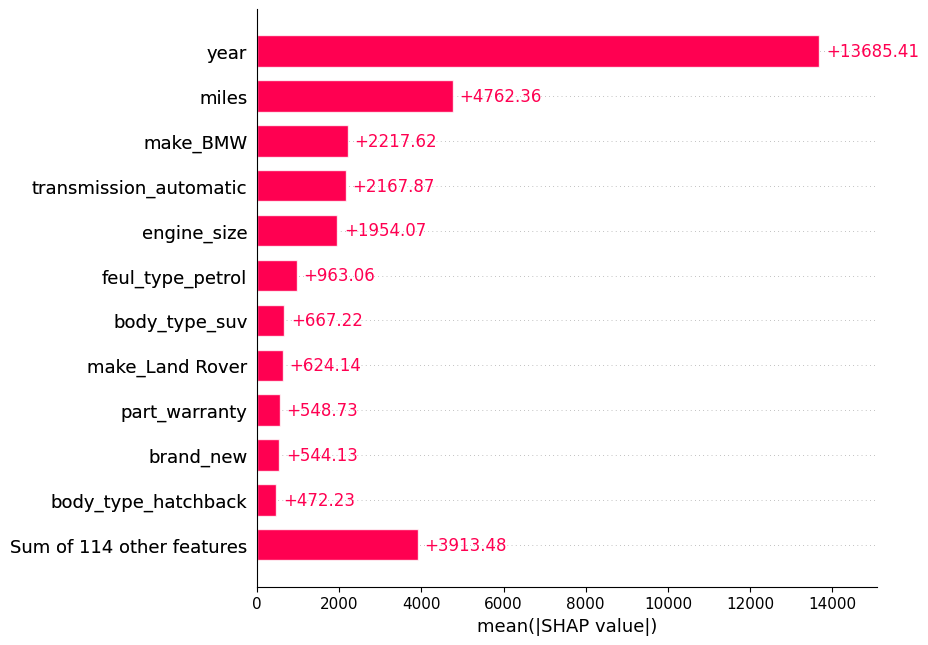

In [ ]:
volvo_high_price = X_test[(df['make_Audi'] == True) & (y_test > 20000)]

single_volvo = volvo_high_price.iloc[0]

real_price_volvo = y_test.loc[single_volvo.name]
predicted_price_volvo = y_pred[single_volvo.name]
difference_volvo = predicted_price_volvo - real_price_volvo

print("Car details with 'make_Volvo' = True and price > 20,000:")
print(single_volvo)
print(f"Real Price: {real_price_volvo}")
print(f"Predicted Price: {predicted_price_volvo}")
print(f"Difference: {difference_volvo}")

miles = single_volvo['miles']
year = single_volvo['year']
engine_size = single_volvo['engine_size']

print(f"Miles: {miles}")
print(f"Year: {year}")
print(f"Engine Size: {engine_size}")

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

single_car_volvo_scaled = X_test_scaled_df.loc[single_volvo.name].values.reshape(1, -1)

explainer = shap.TreeExplainer(model)
shap_values_single = explainer.shap_values(single_car_volvo_scaled)

shap_values_single_explanation = shap.Explanation(values=shap_values_single,
                                                  base_values=explainer.expected_value,
                                                  data=single_car_volvo_scaled,
                                                  feature_names=X_test.columns)

shap.plots.bar(shap_values_single_explanation, max_display=12)


I randomly selected an Audi car with a price greater than 20,000.

The Audi I chose has the following data:

Miles: 0.0

Year: 2022

Engine Size: 190.0

From this data, I can infer that the Audi has a relatively small engine size, but it is a new car. The model's predicted price difference was only -2,222.48.

As shown in the SHAP graph, the model primarily predicts the price based on the car being brand new with 0 miles.

As I mentioned earlier, engine size plays a significant role in price prediction — the larger the engine size, the higher the price. However, in this case, the small engine size doesn't have as much of an impact on the car's price, likely because the car is so new.

## **Code Notebook from Kaggle**

I searched for similar projects using this dataset but didn’t find anything.
I will probably upload my notebook to Kaggle to get feedback and commen

In this project, I worked with a dataset of used cars in England.
I intentionally chose this dataset knowing that it had challenges so that I could tackle them effectively and make the project more meaningful.

After numerous experiments with the data, I realized that in order to use it effectively for predicting the price of a used car based on its features, I needed to process and transform the dataset to achieve a high-accuracy prediction.

One of the challenges I encountered was that the data was not normally distributed. To improve the predictions, I worked on transforming the dataset to follow a more normal distribution.

To improve model performance, I categorized the features into binary, categorical, and numerical data.
For each type, I applied different processing techniques to ensure the dataset was structured optimally for training.

The dataset had missing values, which I handled by filling in data where possible, removing rows with excessive missing values, and analyzing the data for consistency.
I also identified and addressed numerous outliers that were distorting the analysis.
Many features had little to no correlation with the target feature, so I performed feature selection to remove irrelevant columns and kept only those valuable for predicting car prices.

These data cleaning steps were essential for optimizing the dataset for accurate predictions.

Once the dataset was properly prepared, I tested multiple machine learning algorithms to determine which model would provide the best price predictions without overfitting.

The XGBoost model achieved the best results. To further enhance its performance, I applied Grid Search to find the optimal hyperparameters.

To better understand how the model made predictions, I used SHAP values.
I visualized these values in different ways to interpret and explain how each feature influenced the predicted price.

**Conclusion**

In this project, my goal was to achieve the most accurate possible car price predictions by processing the dataset effectively, choosing the right model, and optimizing its performance.